In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(lsmeans))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(export))
R.Version()

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”


$platform
[1] "x86_64-apple-darwin17.0"

$arch
[1] "x86_64"

$os
[1] "darwin17.0"

$system
[1] "x86_64, darwin17.0"

$status
[1] ""

$major
[1] "4"

$minor
[1] "0.2"

$year
[1] "2020"

$month
[1] "06"

$day
[1] "22"

$`svn rev`
[1] "78730"

$language
[1] "R"

$version.string
[1] "R version 4.0.2 (2020-06-22)"

$nickname
[1] "Taking Off Again"

# Import data

In [2]:
data <- read.csv("/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/data/process/fig2_table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
data$vars2 <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
data <- data %>% mutate(lv_tot_tag = (LV_TAG * liver_wt)/1000,
                        EE_norm = avgEE*1000/Lean_mass, 
                        fecal_tot_tag = TG_feces2*fecal_tot_output, 
                        kkcal = Cal_cum/1000,
                        uptake_f = uptake_freq_light + uptake_freq_dark,
                        allMeters = allmeters_light+allmeters_dark,
                        allPeds = pedmeters_light+pedmeters_dark,
                        grooming = allMeters - allPeds); head(data)
txn <- data %>% filter(vars2 == "HFD+TXN"); hfd <- data %>% filter(vars2 == "HFD");
lxn <- data %>% filter(vars2 == "HFD+LXN"); hxn <- data %>% filter(vars2 == "HFD+HXN");
lfd <- data %>% filter(vars2 == "LFD")

,ID,Treatment,Cal_cum,LV_TAG,lipidosis_area_pct,Fat_mass,subq_wt,epi_wat,mesenteric_wt,plasma_TAG,⋯,vars,vars2,lv_tot_tag,EE_norm,fecal_tot_tag,kkcal,uptake_f,allMeters,allPeds,grooming
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,LFD,1425.870,367.77,17.596,11.152,0.40,1.80,0.33,38.547,⋯,LFD,LFD,0.5810766,22.21568,17.55000,1.425870,23,227.4935,190.1555,37.33804
2,2,LFD,1241.231,400.53,0.696,7.357,0.72,1.34,0.48,53.408,⋯,LFD,LFD,0.5126784,21.79943,15.02280,1.241231,26,267.6345,227.4692,40.16536
3,3,LFD,1298.180,379.47,17.311,10.517,0.89,2.08,0.94,68.087,⋯,LFD,LFD,0.5236686,28.79635,13.38480,1.298180,23,251.1943,212.1898,39.00450
4,4,LFD,1812.026,332.67,16.353,12.781,0.78,2.13,0.54,37.492,⋯,LFD,LFD,0.6520332,30.11525,20.70900,1.812026,34,295.1175,237.1283,57.98922
5,5,LFD,1373.638,408.33,5.164,6.385,0.26,0.97,0.32,46.053,⋯,LFD,LFD,0.5634954,22.49855,17.52855,1.373638,29,262.2310,231.9523,30.27869
6,6,LFD,1448.174,454.35,22.362,11.460,0.99,2.07,0.60,45.932,⋯,LFD,LFD,0.7224165,25.35729,7.85460,1.448174,50,234.2913,177.0421,57.24920


# Set theme, import functions

In [3]:
theme_set(theme_bw())

In [4]:
theme_legend2 = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=5)),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_text(size = 13),
	axis.title.x = element_text(size = 15,
                               margin = margin(t=10, r=5, b=0, l=0)),
    plot.title = element_text(size = 15, face = "bold"),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = "none",
	plot.margin = unit(c(0.5,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

In [5]:
source("/Users/yangzhang/Box/Zhang_Projects/MANUSCRIPT_PPAR/github_repo/PPAR/manuscript/figures/src/ggplotRegression.R")

In [6]:
mycolor <- c("#0080ff", "#ffa500", "red", "darkgreen", "black")
mycolor_alpha <- c("#8AB5F9", "#F8CB89", "#F08581", "#87A57E", "#797979")

In [7]:
Contrasts <- list(
    'LFD vs HFD' = c(-1, 0, 0, 0, 1),
    'LXN vs HFD' = c(-1, 1, 0, 0, 0),
    'HXN vs HFD' = c(-1, 0, 1, 0, 0),
    'TXN vs HFD' = c(-1, 0, 0, 1, 0))

# Figures

## - A. all meters boxplot

In [8]:
model <- lm(allPeds ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate   SE df t.ratio p.value
 LFD vs HFD     69.1 17.7 54 3.910   0.0003 
 LXN vs HFD     34.8 17.7 54 1.969   0.0541 
 HXN vs HFD     12.7 17.7 54 0.719   0.4754 
 TXN vs HFD     50.7 18.1 54 2.804   0.0070 


In [9]:
A <- ggplot(data = data, aes(x = vars2, y = allPeds, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="m",title="A. Directed ambulatory locomotion per light-dark cycle") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+LXN", "HFD+TXN", "LFD"),
                       allPeds = c(277, 277, 277))
A <- A + geom_text(data = label.df, label = c("*", "**", "***"), color='red', size = 8)

## - B. other activities boxplot

In [10]:
model <- lm(grooming ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate   SE df t.ratio p.value
 LFD vs HFD    0.607 3.70 54 0.164   0.8702 
 LXN vs HFD    4.629 3.70 54 1.251   0.2164 
 HXN vs HFD    3.081 3.70 54 0.832   0.4088 
 TXN vs HFD    8.510 3.78 54 2.249   0.0286 


In [11]:
B <- ggplot(data = data, aes(x = vars2, y = grooming, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="m",title="B. Fine movements per light-dark cycle \ngrooming, scratching, etc") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+TXN"),
                       grooming = c(50))
B <- B + geom_text(data = label.df, label = c("*"), color='red', size = 8)

## - C. Food intake frequency

In [12]:
model <- lm(uptake_f ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate   SE df t.ratio p.value
 LFD vs HFD    1.333 2.51 54 0.532   0.5968 
 LXN vs HFD    6.083 2.51 54 2.428   0.0185 
 HXN vs HFD    4.917 2.51 54 1.962   0.0549 
 TXN vs HFD    0.174 2.56 54 0.068   0.9460 


In [13]:
C <- ggplot(data = data, aes(x = vars2, y = uptake_f, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="",title="C. Food intake frequency per light-dark cycle") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+LXN", "HFD+HXN"),
                       uptake_f = c(45,50))
C <- C + geom_text(data = label.df, label = c("*", "*"), color='red', size = 8)

In [14]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row1 <- (A | B | C) + plot_layout(nrow = 1, ncol=3)

In [15]:
lfd_avgEE_allPeds <- ggplotRegression(lm(avgEE ~ allPeds, data = lfd), "black") + 
                        labs(title = "A-1 LFD", x = "Directed ambulatory locomotion (m)", y = "energy expenditure")+ theme_legend2()
hfd_avgEE_allPeds <- ggplotRegression(lm(avgEE ~ allPeds, data = hfd), "#0080ff")+ 
                        labs(title = "A-2 HFD", x = "Directed ambulatory locomotion (m)", y = "energy expenditure")+ theme_legend2()
lxn_avgEE_allPeds <- ggplotRegression(lm(avgEE ~ allPeds, data = lxn), "#ffa500")+ 
                        labs(title = "A-3 HFD+LXN", x = "Directed ambulatory locomotion (m)", y = "energy expenditure")+ theme_legend2()
hxn_avgEE_allPeds <- ggplotRegression(lm(avgEE ~ allPeds, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "A-4 HFD+HXN", x = "Directed ambulatory locomotion (m)", y = "energy expenditure")+ theme_legend2()
txn_avgEE_allPeds <- ggplotRegression(lm(avgEE ~ allPeds, data = txn), "darkgreen")+ 
                        labs(title = "A-5 HFD+TXN", x = "Directed ambulatory locomotion (m)", y = "energy expenditure")+ theme_legend2()

In [16]:
lfd_avgEE_grooming <- ggplotRegression(lm(avgEE ~ grooming, data = lfd), "black") + 
                        labs(title = "B-1 LFD", x = "Fine movements (m)", y = "energy expenditure")+ theme_legend2()
hfd_avgEE_grooming <- ggplotRegression(lm(avgEE ~ grooming, data = hfd), "#0080ff")+ 
                        labs(title = "B-2 HFD", x = "Fine movements (m)", y = "energy expenditure")+ theme_legend2()
lxn_avgEE_grooming <- ggplotRegression(lm(avgEE ~ grooming, data = lxn), "#ffa500")+ 
                        labs(title = "B-3 HFD+LXN", x = "Fine movements (m)", y = "energy expenditure")+ theme_legend2()
hxn_avgEE_grooming <- ggplotRegression(lm(avgEE ~ grooming, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "B-4 HFD+HXN", x = "Fine movements (m)", y = "energy expenditure")+ theme_legend2()
txn_avgEE_grooming <- ggplotRegression(lm(avgEE ~ grooming, data = txn), "darkgreen")+ 
                        labs(title = "B-5 HFD+TXN", x = "Fine movements (m)", y = "energy expenditure")+ theme_legend2()

In [17]:
lfd_avgEE_food <- ggplotRegression(lm(allPeds ~ uptake_f, data = lfd), "black") + 
                        labs(title = "C-1 LFD", x = "Food intake frequency", y = "Directed ambulatory locomotion (m)")+ theme_legend2()
hfd_avgEE_food <- ggplotRegression(lm(allPeds ~ uptake_f, data = hfd), "#0080ff")+ 
                        labs(title = "C-2 HFD", x = "Food intake frequency", y = "Directed ambulatory locomotion (m)")+ theme_legend2()
lxn_avgEE_food <- ggplotRegression(lm(allPeds ~ uptake_f, data = lxn), "#ffa500")+ 
                        labs(title = "C-3 HFD+LXN", x = "Food intake frequency", y = "Directed ambulatory locomotion (m)")+ theme_legend2()
hxn_avgEE_food <- ggplotRegression(lm(allPeds ~ uptake_f, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "C-4 HFD+HXN", x = "Food intake frequency", y = "Directed ambulatory locomotion (m)")+ theme_legend2()
txn_avgEE_food <- ggplotRegression(lm(allPeds ~ uptake_f, data = txn), "darkgreen")+ 
                        labs(title = "C-5 HFD+TXN", x = "Food intake frequency", y = "Directed ambulatory locomotion (m)")+ theme_legend2()

In [18]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row2 <- (lfd_avgEE_allPeds | lfd_avgEE_grooming | lfd_avgEE_food) + plot_layout(nrow = 1, ncol = 3)

In [19]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row3 <- (hfd_avgEE_allPeds | hfd_avgEE_grooming | hfd_avgEE_food) + plot_layout(nrow = 1, ncol = 3)

In [20]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row4 <- (lxn_avgEE_allPeds | lxn_avgEE_grooming | lxn_avgEE_food) + plot_layout(nrow = 1, ncol = 3)

In [21]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row5 <- (hxn_avgEE_allPeds | hxn_avgEE_grooming | hxn_avgEE_food) + plot_layout(nrow = 1, ncol = 3)

In [22]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 150)
row6 <- (txn_avgEE_allPeds | txn_avgEE_grooming | txn_avgEE_food) + plot_layout(nrow = 1, ncol = 3)

# put together

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



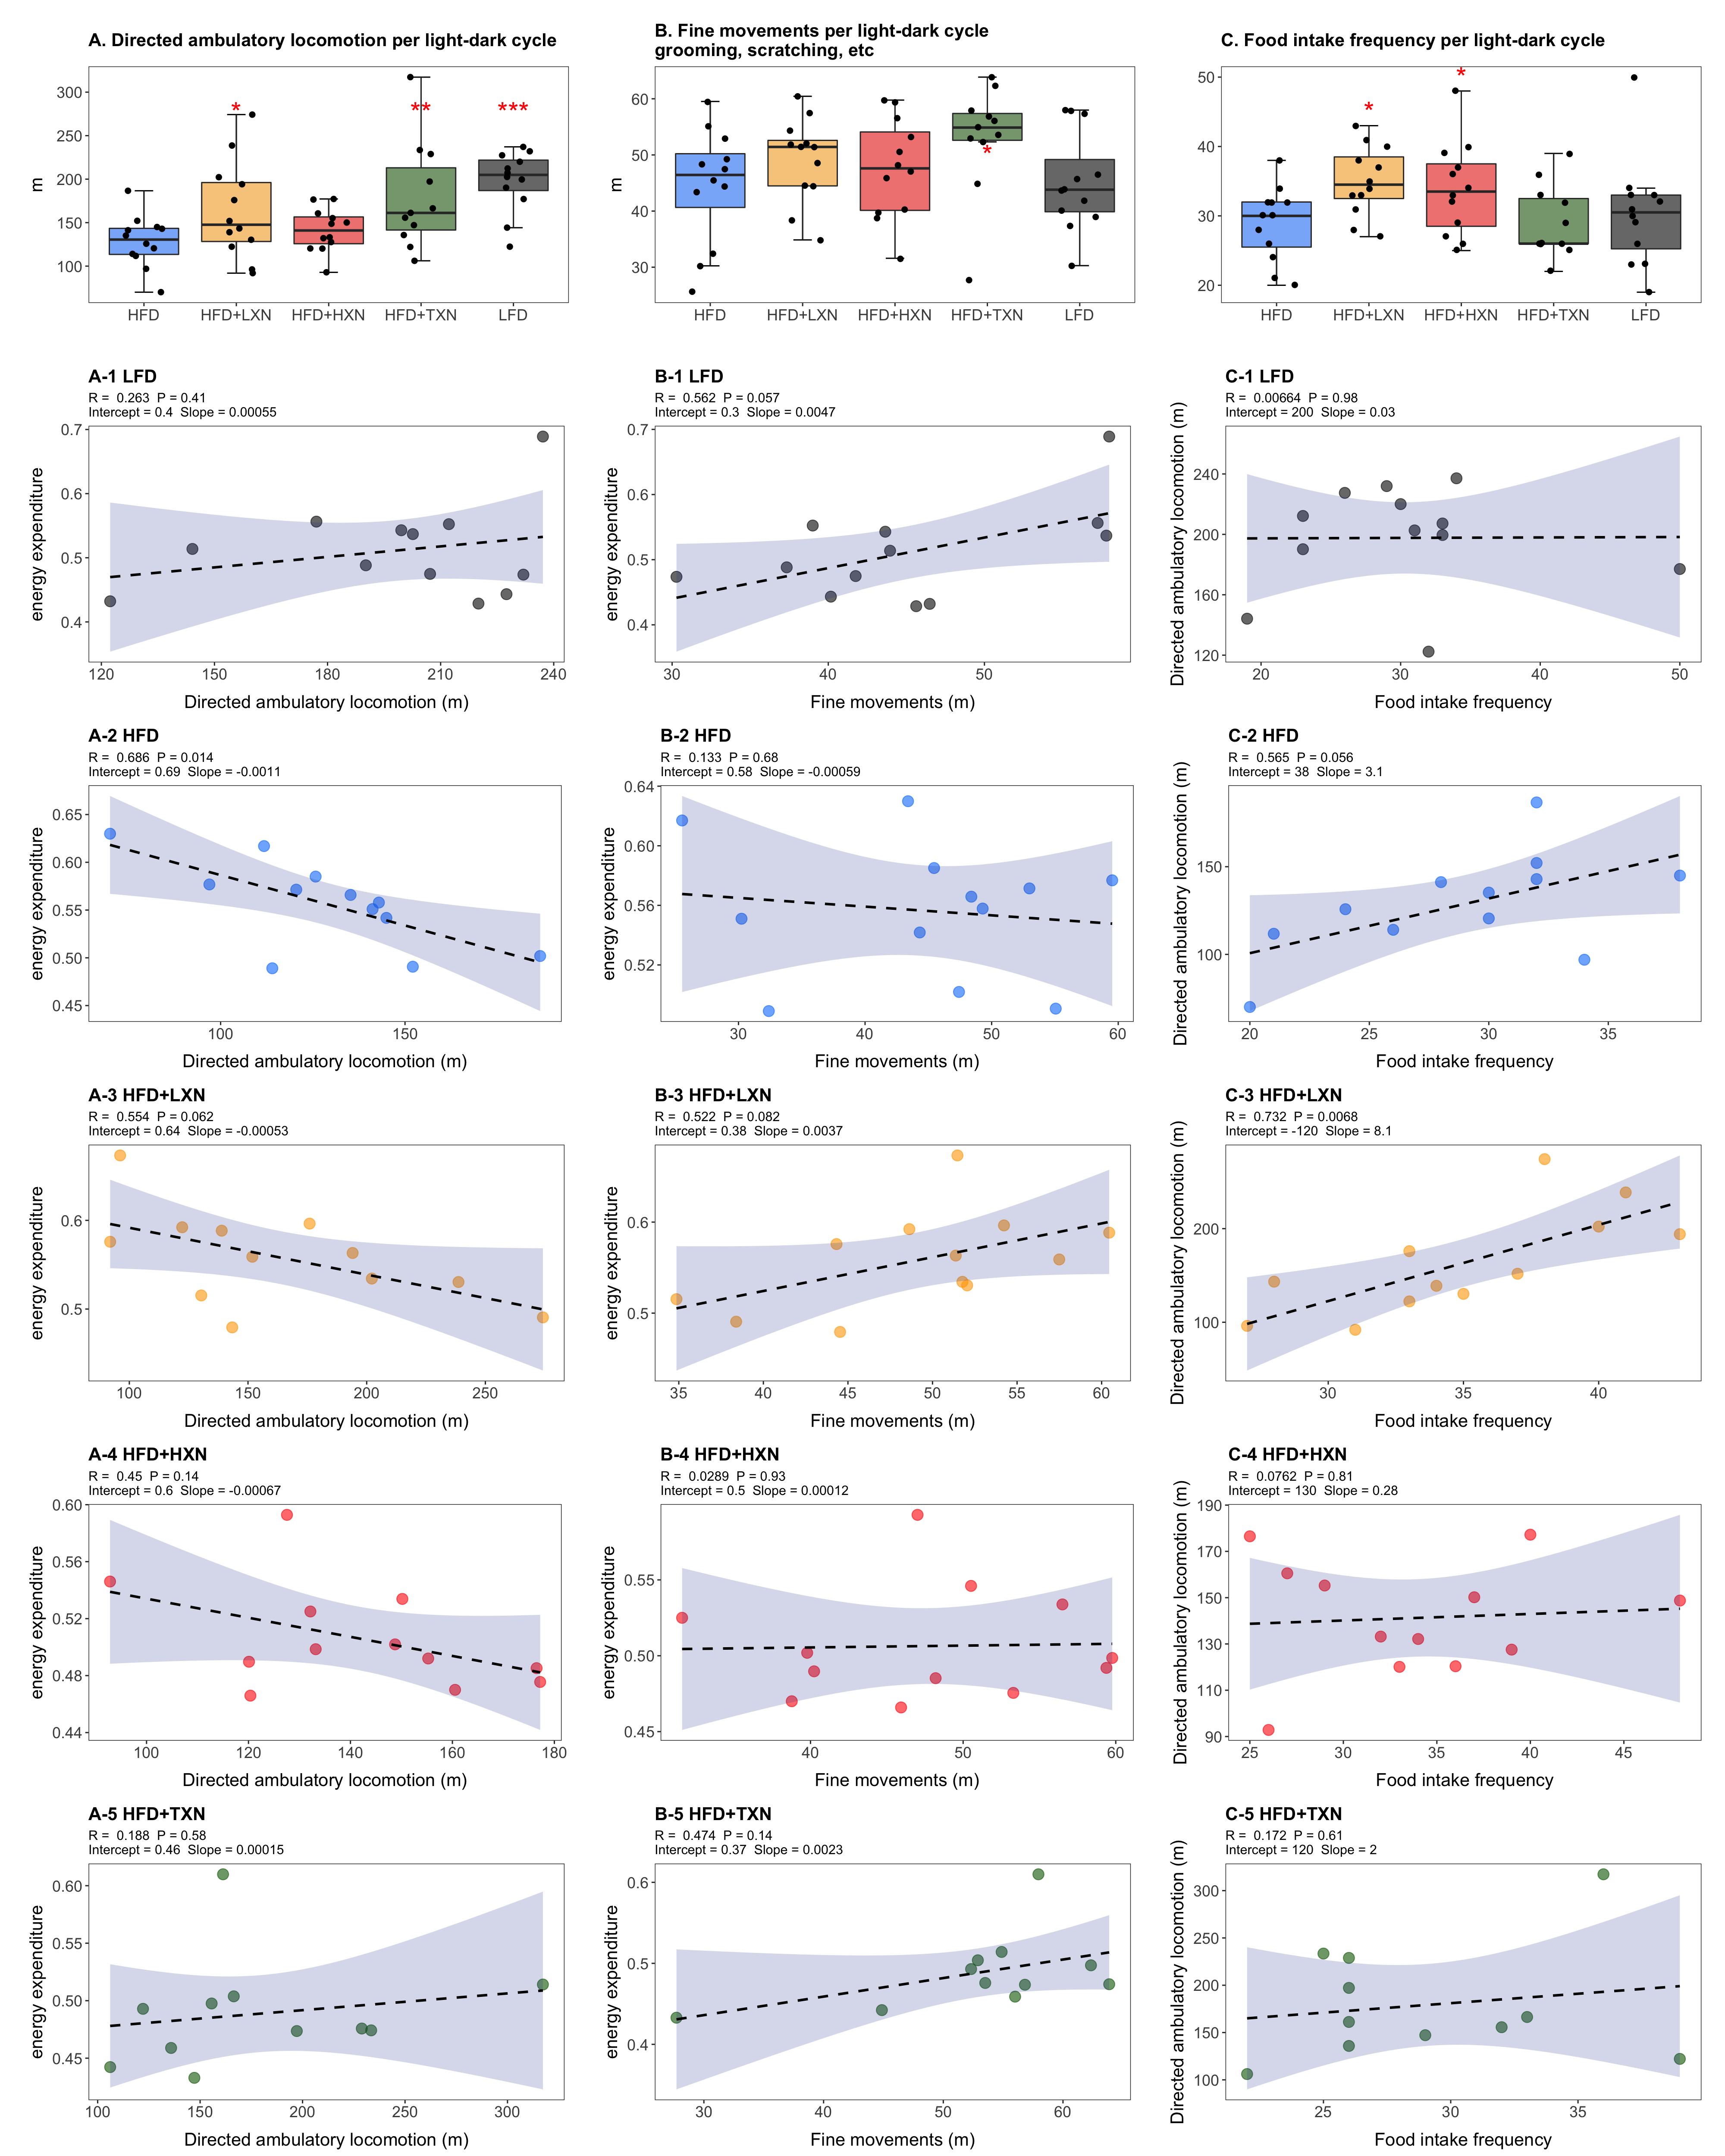

In [23]:
options(repr.plot.width = 20, repr.plot.height = 25, repr.plot.res = 200)
(figure3 <- wrap_plots(row1, row2, row3, row4, row5, row6, nrow=6))

In [24]:
graph2pdf(figure3, "figure3.pdf", width = 20, height = 25)
#graph2svg(figure5, "figure5.svg", width = 20, height = 25)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Exported graph as figure3.pdf

